# Performative Prediciton: A Case Study in Strategic Classification

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from data_prep import load_data
from strategic import best_response
from optimization import logistic_regression, evaluate_loss

## 1) Data 

We perform our experiments on the *Give me a credit* dataset available at https://www.kaggle.com/c/GiveMeSomeCredit. The dataset contains features of individuals and an indicator varaible on whether they defaulted on a loan or not.

In [2]:
# load data
np.random.seed(0) 
X, Y, data = load_data('path_to_file/file.cvs')
n = X.shape[0]
d = X.shape[1] - 1

FileNotFoundError: [Errno 2] File b'path_to_file/file.cvs' does not exist: b'path_to_file/file.cvs'

Define a subset of features that can be modified strategically

In [5]:
strat_features = np.array([1, 6, 8]) - 1 # for later indexing

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


## 2) Simulation

### Initial ERM Classifier

We train a logistic regression classifier on the given set of features and labels. 
This corresponds to the classical supervised learning procedure.

In [6]:
# fit logistic regression model we treat as the truth
lam = 1.0/n
theta_true, loss_list, smoothness = logistic_regression(X, Y, lam, 'Exact')
strat_norm = np.linalg.norm(theta_true[strat_features])

print('Accuracy: ', ((X.dot(theta_true) > 0)  == Y).mean())
print('Loss: ', loss_list[-1])
print('Condition Number: ', lam / (smoothness + lam))
print('Norm: ', np.linalg.norm(theta_true))
print('Strat Features, Norm: ', theta_true[strat_features], strat_norm)

Accuracy:  0.7207059977120445
Loss:  0.6099486754166711
Condition Number:  1.167406443275854e-05
Norm:  2.4515844200763777
Strat Features, Norm:  [-0.0068505   0.01096926  0.09788595] 0.09873658927305821


### Repeated ERM

We simulate the effect of performativity. Therefore we perform `num_iters` rounds. In each round the following three steps are performed: i) we train an ERM classifier on the current set of features, ii) the classifier is deployed and iii) the individuals react strategically to the deployed calssifier, inducing a new set of fetaures for the next round

a) configure experiment

In [8]:
# problems parameters
num_iters    = 25
eps_list = [.01, 1, 100, 1000]
num_eps  = len(eps_list)

# define which method to run: 'RRM' or 'RGD'
method = 'RRM'  

b) setup summary statistics

In [9]:
theta_list         = [[np.copy(theta_true)] for _ in range(num_eps)]
theta_gaps         = [[] for _ in range(num_eps)]
ll_list            = [[] for _ in range(num_eps)]
acc_list_start     = [[] for _ in range(num_eps)]
acc_list_end       = [[] for _ in range(num_eps)]
lp_list_start      = [[] for _ in range(num_eps)]
lp_list_end        = [[] for _ in range(num_eps)]
condition_num_list = [[] for _ in range(num_eps)]
gd_cutoff_list     = [[] for _ in range(num_eps)]

c) simulate experiment

In [11]:
for c, eps in enumerate(eps_list):
    
    # initial theta
    theta = np.copy(theta_true)

    print('Running epsilon =  {}\n'.format(eps))
    
    for t in range(num_iters):
        
        # adjust distribution to current theta
        X_strat = best_response(X, theta, eps, strat_features)
        
        # evaluate initial loss on the current distribution
        # performative loss value of previous theta
        loss_start = evaluate_loss(X_strat, Y, theta, lam, strat_features)
        acc = ((X_strat.dot(theta) > 0) == Y).mean()
        
        acc_list_start[c].append(acc)
        lp_list_start[c].append(loss_start)
        
        # learn on induced distribution
        theta_init = np.zeros(d+1) if method == 'Exact' else np.copy(theta)
        
        theta_new, ll, logistic_smoothness = logistic_regression(X_strat, Y, lam, method, tol=1e-7, 
                                                                 theta_init=theta_init)
        
        # keep track of statistics
        ll_list[c].append(ll)
        theta_gaps[c].append(np.linalg.norm(theta_new - theta) / strat_norm)
        theta_list[c].append(np.copy(theta_new))
        
        smoothness = max(logistic_smoothness + lam, 2) # lipschitz gradient
        
        condition_num_list[c].append(lam / smoothness)
        gd_cutoff_list[c].append(lam / ((smoothness + lam) * (1 + 1.5 * smoothness)))

        # evaluate final loss on the current distribution
        loss_end = evaluate_loss(X_strat, Y, theta_new, lam, strat_features)
        acc = ((X_strat.dot(theta_new) > 0) == Y).mean()
        
        lp_list_end[c].append(loss_end)        
        acc_list_end[c].append(acc)
        
        theta = np.copy(theta_new)


Running epsilon =  0.01


Running epsilon =  1


Running epsilon =  100


Running epsilon =  1000



## 3) Visualization of Results

In [24]:
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'Times New Roman'

%matplotlib inline

 ### Perfromative Risk
 
 We visualize the perfromative risk during the repeated risk minimization procedure. We illustrate the risk at the beginning and at the end of each round, correcting the two values with a blue line and indicate the distribution shift with a dashed green line.

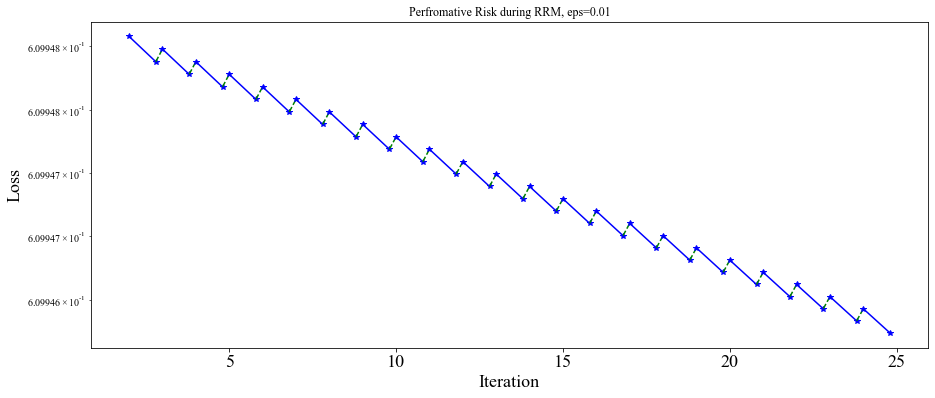

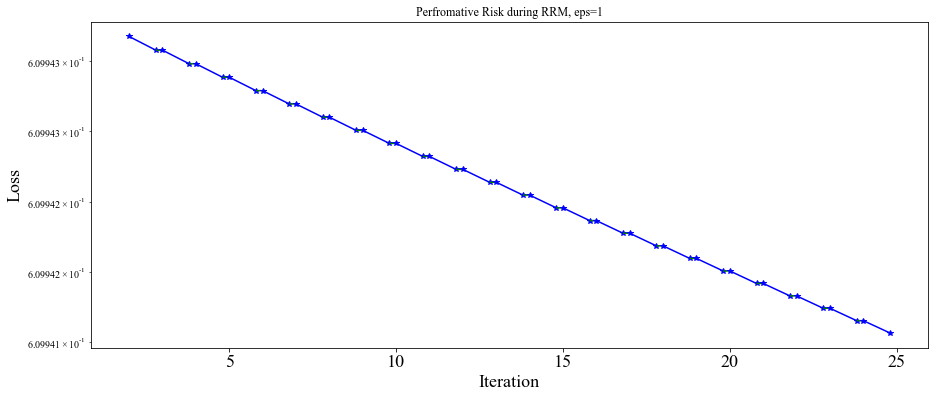

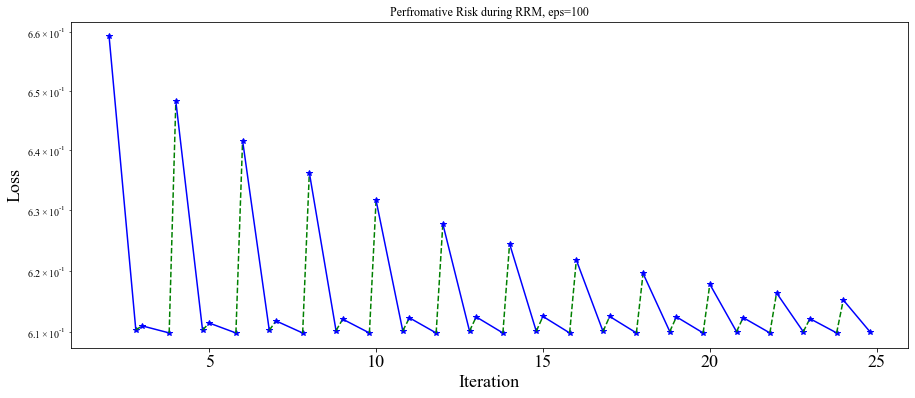

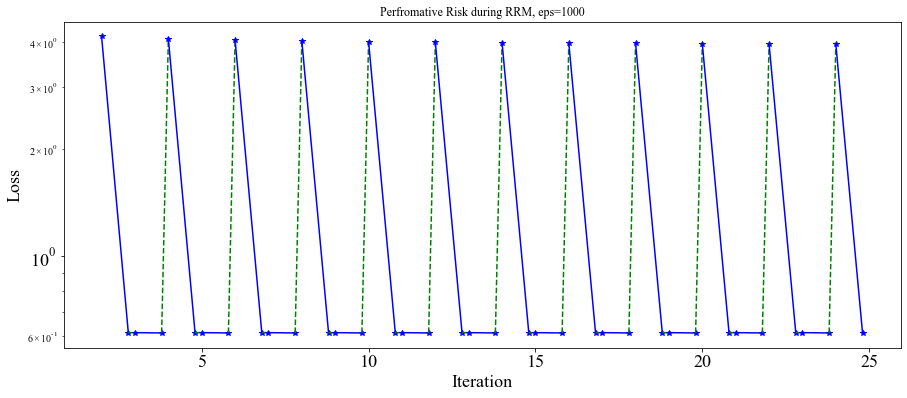

In [31]:
# visualize loss trajectory

for c in range(num_eps):
    plt.figure(figsize=(15,6))
    offset = 0.8
    plt.title('Perfromative Risk during {}, eps={}'.format(method,eps_list[c]))
    for i in range(2,num_iters):
        plt.plot([i,i+offset],[lp_list_start[c][i],lp_list_end[c][i]],'b*-')
        if i<num_iters-1:
            plt.plot([i+offset, i+1],[lp_list_end[c][i],lp_list_start[c][i+1]],'g--')

    plt.xlabel('Iteration',fontsize = 18)
    plt.ylabel('Loss',fontsize = 18) 
    plt.tick_params(labelsize=18)
    plt.yscale('log')

### Accuracy

we show how the accuracy evolves to check that the loss is a good surregate model 

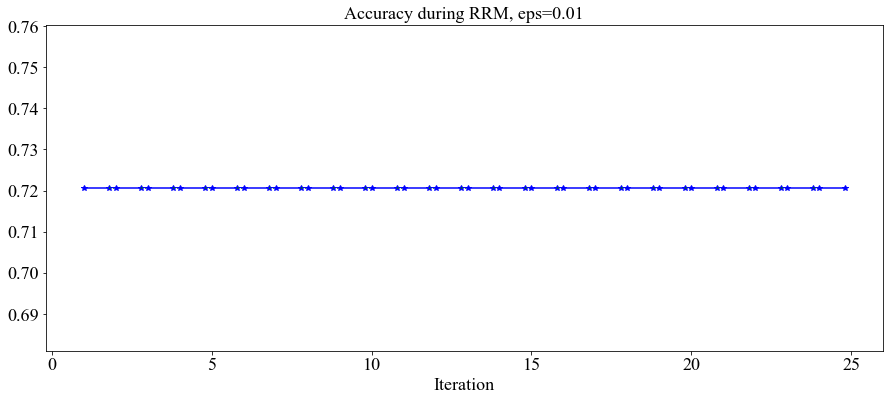

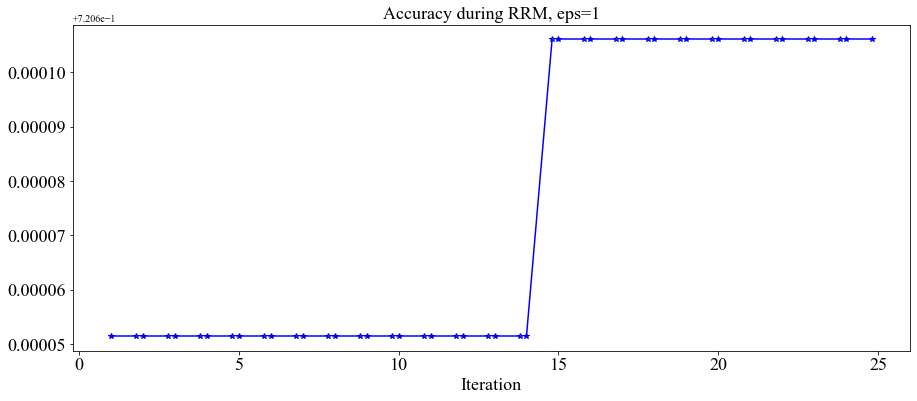

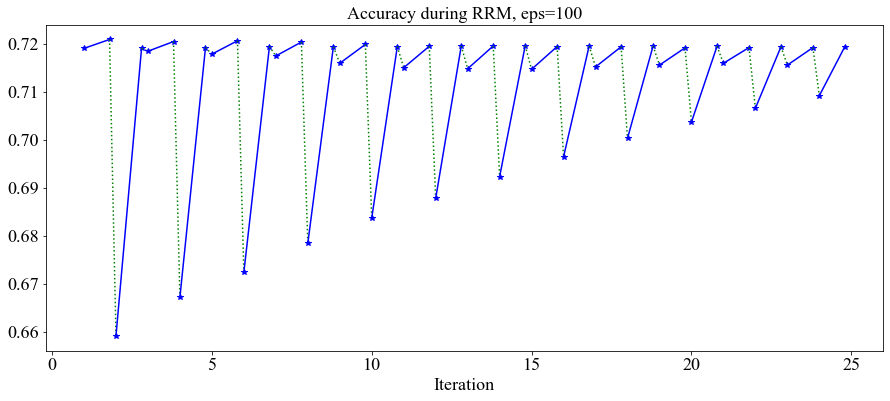

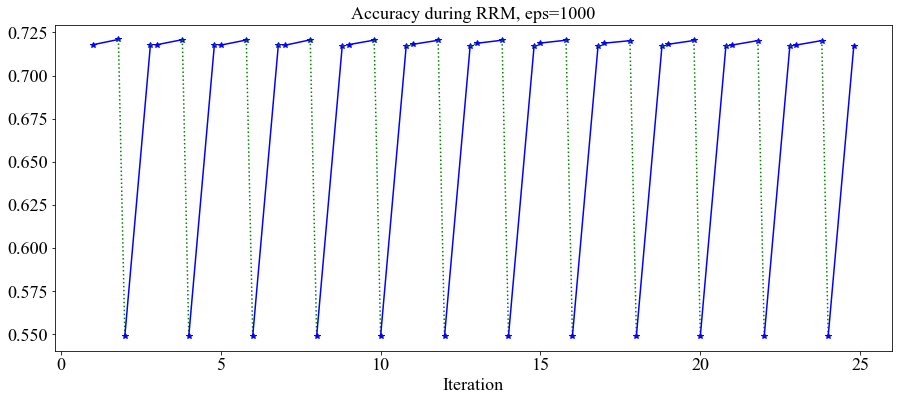

In [29]:
# visualize accuracy trajectory

for c in range(num_eps):
    fig = plt.figure(figsize=(15,6))
    ax = fig.gca()
    offset = 0.8
    
    for i in range(1,num_iters):
        # gain of RRM step
        plt.plot([i,i+offset],[acc_list_start[c][i],acc_list_end[c][i]],'b*-')
        if i<num_iters-1:
            plt.plot([i+offset, i+1],[acc_list_end[c][i],acc_list_start[c][i+1]],'g:')

    plt.xlabel('Iteration', fontsize = 18)
    plt.tick_params(labelsize=18)
    plt.title('Accuracy during {}, eps='{}'.format(method',eps_list[c]), fontsize = 18)

### Distance between iterates

We plot the distance between consecutive iterates. This is the quantity bounded by our theorems

In [3]:
processed_theta_gaps = [[x for x in tg if x != 0.0] for tg in theta_gaps]

for i, c in enumerate(list(range(num_eps))):

    legend_entry = '$\\varepsilon$ = {}'.format(int(eps_list[c]))
    iters_before_zero = len(processed_theta_gaps[c])

    if i == 0:
        legend_entry = '$\\varepsilon$ = {}'.format(eps_list[c])
        plt.plot(processed_theta_gaps[c],label = legend_entry, linewidth=3,  alpha=1, zorder=8,
                 markevery=[iters_before_zero - 1], marker='*', linestyle=(0, (1, 1)))
    elif i == 1:
        plt.plot(processed_theta_gaps[c],label = legend_entry, linewidth=3,  alpha=1,
                 markevery=[iters_before_zero - 1], marker='*', linestyle='solid')
    elif i == 2:
        plt.plot(processed_theta_gaps[c],label = legend_entry, linewidth=3, alpha=1, zorder=10)
    else:
         plt.plot(processed_theta_gaps[c],label = legend_entry, linewidth=3, alpha=.6)

plt.title('{}'.format(method), fontsize=18)
plt.xlabel('Iteration $t$',fontsize=18)
plt.ylabel(r'$c \cdot \|\theta_{t+1} - \theta_{t}\|_2 $', fontsize=14)
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.legend(loc='center right', fontsize=18)

NameError: name 'theta_gaps' is not defined

In [15]:
A = np.zeros((5, 4))
print(A)
A[:, np.array([0, 2, 3])] += np.array((4, 7, 9))
print(A)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[4. 0. 7. 9.]
 [4. 0. 7. 9.]
 [4. 0. 7. 9.]
 [4. 0. 7. 9.]
 [4. 0. 7. 9.]]
